#### Import Libraries

In [0]:
import sys
import numpy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from collections import OrderedDict
import os
import time

import numpy as np
import functools
from PIL import Image
import IPython.display
import time
import cv2

In [2]:
# check that a gpu is available
torch.cuda.device_count()

1

In [0]:
# Set up cudnn.benchmark for free speed.
torch.backends.cudnn.benchmark = True

In [0]:
use_gpu = True if torch.cuda.is_available() else False

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from torch import device as device_

device = device_("cuda")

### Facial Embedding Network

In [7]:
!wget https://github.com/thnkim/OpenFacePytorch/raw/master/openface_20180119.pth

--2019-12-15 15:40:52--  https://github.com/thnkim/OpenFacePytorch/raw/master/openface_20180119.pth
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thnkim/OpenFacePytorch/master/openface_20180119.pth [following]
--2019-12-15 15:40:52--  https://raw.githubusercontent.com/thnkim/OpenFacePytorch/master/openface_20180119.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15008563 (14M) [application/octet-stream]
Saving to: ‘openface_20180119.pth’

openface_20180119.p 100%[===================>]  14.31M  --.-KB/s    in 0.08s   

2019-12-15 15:40:53 (176 MB/s) - ‘openface_20180119.pth’ saved [15008563/1500

In [0]:
embedding_dir = "."

#### SpatialCrossMapLRN

In [0]:
# This is a simple modification of https://github.com/pytorch/pytorch/blob/master/torch/legacy/nn/SpatialCrossMapLRN.py.

import torch
# from torch.legacy.nn.Module import Module
# from torch.legacy.nn.utils import clear

from torch.nn.modules import Module
def clear(self, *args):
    if len(args) == 1 and isinstance(args[0], list):
        args = args[0]

    def _clear(f):
        if not hasattr(self, f):
            return
        attr = getattr(self, f)
        if isinstance(attr, torch.Tensor):
            attr.set_()
        elif isinstance(attr, list):
            del attr[:]
        else:
            setattr(self, f, None)
    for key in args:
        _clear(key)
    return self


class SpatialCrossMapLRN_temp(Module):

	def __init__(self, size, alpha=1e-4, beta=0.75, k=1, gpuDevice=0):
		super(SpatialCrossMapLRN_temp, self).__init__()

		self.size = size
		self.alpha = alpha
		self.beta = beta
		self.k = k
		self.scale = None
		self.paddedRatio = None
		self.accumRatio = None
		self.gpuDevice = gpuDevice
		self.output = None

	def forward(self, input):
		assert input.dim() == 4

		if self.scale is None:
			self.scale = input.new()
			
		if self.output is None:
			self.output = input.new()

		batchSize = input.size(0)
		channels = input.size(1)
		inputHeight = input.size(2)
		inputWidth = input.size(3)

		if input.is_cuda:	
			self.output = self.output.cuda(self.gpuDevice)
			self.scale = self.scale.cuda(self.gpuDevice)

		self.output.resize_as_(input)
		self.scale.resize_as_(input)

		# use output storage as temporary buffer
		inputSquare = self.output
		torch.pow(input, 2, out=inputSquare)

		prePad = int((self.size - 1) / 2 + 1)
		prePadCrop = channels if prePad > channels else prePad

		scaleFirst = self.scale.select(1, 0)
		scaleFirst.zero_()
		# compute first feature map normalization
		for c in range(prePadCrop):
			scaleFirst.add_(inputSquare.select(1, c))

		# reuse computations for next feature maps normalization
		# by adding the next feature map and removing the previous
		for c in range(1, channels):
			scalePrevious = self.scale.select(1, c - 1)
			scaleCurrent = self.scale.select(1, c)
			scaleCurrent.copy_(scalePrevious)
			if c < channels - prePad + 1:
				squareNext = inputSquare.select(1, c + prePad - 1)
				scaleCurrent.add_(1, squareNext)

			if c > prePad:
				squarePrevious = inputSquare.select(1, c - prePad)
				scaleCurrent.add_(-1, squarePrevious)

		self.scale.mul_(self.alpha / self.size).add_(self.k)

		torch.pow(self.scale, -self.beta, out=self.output)
		self.output.mul_(input)

		return self.output

	def updateOutput(self, input):
		assert input.dim() == 4

		if self.scale is None:
			self.scale = input.new()
			
		if self.output is None:
			self.output = input.new()

		batchSize = input.size(0)
		channels = input.size(1)
		inputHeight = input.size(2)
		inputWidth = input.size(3)

		if input.is_cuda:	
			self.output = self.output.cuda(self.gpuDevice)
			self.scale = self.scale.cuda(self.gpuDevice)

		self.output.resize_as_(input)
		self.scale.resize_as_(input)

		# use output storage as temporary buffer
		inputSquare = self.output
		torch.pow(input, 2, out=inputSquare)

		prePad = int((self.size - 1) / 2 + 1)
		prePadCrop = channels if prePad > channels else prePad

		scaleFirst = self.scale.select(1, 0)
		scaleFirst.zero_()
		# compute first feature map normalization
		for c in range(prePadCrop):
			scaleFirst.add_(inputSquare.select(1, c))

		# reuse computations for next feature maps normalization
		# by adding the next feature map and removing the previous
		for c in range(1, channels):
			scalePrevious = self.scale.select(1, c - 1)
			scaleCurrent = self.scale.select(1, c)
			scaleCurrent.copy_(scalePrevious)
			if c < channels - prePad + 1:
				squareNext = inputSquare.select(1, c + prePad - 1)
				scaleCurrent.add_(1, squareNext)

			if c > prePad:
				squarePrevious = inputSquare.select(1, c - prePad)
				scaleCurrent.add_(-1, squarePrevious)

		self.scale.mul_(self.alpha / self.size).add_(self.k)

		torch.pow(self.scale, -self.beta, out=self.output)
		self.output.mul_(input)

		return self.output

	def updateGradInput(self, input, gradOutput):
		assert input.dim() == 4

		batchSize = input.size(0)
		channels = input.size(1)
		inputHeight = input.size(2)
		inputWidth = input.size(3)

		if self.paddedRatio is None:
			self.paddedRatio = input.new()
		if self.accumRatio is None:
			self.accumRatio = input.new()
		self.paddedRatio.resize_(channels + self.size - 1, inputHeight, inputWidth)
		self.accumRatio.resize_(inputHeight, inputWidth)

		cacheRatioValue = 2 * self.alpha * self.beta / self.size
		inversePrePad = int(self.size - (self.size - 1) / 2)

		self.gradInput.resize_as_(input)
		torch.pow(self.scale, -self.beta, out=self.gradInput).mul_(gradOutput)

		self.paddedRatio.zero_()
		paddedRatioCenter = self.paddedRatio.narrow(0, inversePrePad, channels)
		for n in range(batchSize):
			torch.mul(gradOutput[n], self.output[n], out=paddedRatioCenter)
			paddedRatioCenter.div_(self.scale[n])
			torch.sum(self.paddedRatio.narrow(0, 0, self.size - 1), 0, out=self.accumRatio)
			for c in range(channels):
				self.accumRatio.add_(self.paddedRatio[c + self.size - 1])
				self.gradInput[n][c].addcmul_(-cacheRatioValue, input[n][c], self.accumRatio)
				self.accumRatio.add_(-1, self.paddedRatio[c])

		return self.gradInput

	def clearState(self):
		clear(self, 'scale', 'paddedRatio', 'accumRatio')
		return super(SpatialCrossMapLRN_temp, self).clearState()
	

In [0]:
class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input


class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))


#
def Conv2d(in_dim, out_dim, kernel, stride, padding):
    l = torch.nn.Conv2d(in_dim, out_dim, kernel, stride=stride, padding=padding)
    return l

def BatchNorm(dim):
    l = torch.nn.BatchNorm2d(dim)
    return l

def CrossMapLRN(size, alpha, beta, k=1.0, gpuDevice=0):
    if SpatialCrossMapLRN_temp is not None:
        lrn = SpatialCrossMapLRN_temp(size, alpha, beta, k, gpuDevice=gpuDevice)
        n = Lambda( lambda x,lrn=lrn: Variable(lrn.forward(x.data).cuda(gpuDevice)) if x.data.is_cuda else Variable(lrn.forward(x.data)) )
    else:
        n = nn.LocalResponseNorm(size, alpha, beta, k).cuda(gpuDevice)
    return n

def Linear(in_dim, out_dim):
    l = torch.nn.Linear(in_dim, out_dim)
    return l


class Inception(nn.Module):
    def __init__(self, inputSize, kernelSize, kernelStride, outputSize, reduceSize, pool, useBatchNorm, reduceStride=None, padding=True):
        super(Inception, self).__init__()
        #
        self.seq_list = []
        self.outputSize = outputSize

        #
        # 1x1 conv (reduce) -> 3x3 conv
        # 1x1 conv (reduce) -> 5x5 conv
        # ...
        for i in range(len(kernelSize)):
            od = OrderedDict()
            # 1x1 conv
            od['1_conv'] = Conv2d(inputSize, reduceSize[i], (1, 1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['2_bn'] = BatchNorm(reduceSize[i])
            od['3_relu'] = nn.ReLU()
            # nxn conv
            pad = int(numpy.floor(kernelSize[i] / 2)) if padding else 0
            od['4_conv'] = Conv2d(reduceSize[i], outputSize[i], kernelSize[i], kernelStride[i], pad)
            if useBatchNorm:
                od['5_bn'] = BatchNorm(outputSize[i])
            od['6_relu'] = nn.ReLU()
            #
            self.seq_list.append(nn.Sequential(od))

        ii = len(kernelSize)
        # pool -> 1x1 conv
        od = OrderedDict()
        od['1_pool'] = pool
        if ii < len(reduceSize) and reduceSize[ii] is not None:
            i = ii
            od['2_conv'] = Conv2d(inputSize, reduceSize[i], (1,1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['3_bn'] = BatchNorm(reduceSize[i])
            od['4_relu'] = nn.ReLU()
        #
        self.seq_list.append(nn.Sequential(od))
        ii += 1

        # reduce: 1x1 conv (channel-wise pooling)
        if ii < len(reduceSize) and reduceSize[ii] is not None:
            i = ii
            od = OrderedDict()
            od['1_conv'] = Conv2d(inputSize, reduceSize[i], (1,1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['2_bn'] = BatchNorm(reduceSize[i])
            od['3_relu'] = nn.ReLU()
            self.seq_list.append(nn.Sequential(od))

        self.seq_list = nn.ModuleList(self.seq_list)


    def forward(self, input):
        x = input

        ys = []
        target_size = None
        depth_dim = 0
        for seq in self.seq_list:
            #print(seq)
            #print(self.outputSize)
            #print('x_size:', x.size())
            y = seq(x)
            y_size = y.size()
            #print('y_size:', y_size)
            ys.append(y)
            #
            if target_size is None:
                target_size = [0] * len(y_size)
            #
            for i in range(len(target_size)):
                target_size[i] = max(target_size[i], y_size[i])
            depth_dim += y_size[1]

        target_size[1] = depth_dim
        #print('target_size:', target_size)

        for i in range(len(ys)):
            y_size = ys[i].size()
            pad_l = int((target_size[3] - y_size[3]) // 2)
            pad_t = int((target_size[2] - y_size[2]) // 2)
            pad_r = target_size[3] - y_size[3] - pad_l
            pad_b = target_size[2] - y_size[2] - pad_t
            ys[i] = F.pad(ys[i], (pad_l, pad_r, pad_t, pad_b))

        output = torch.cat(ys, 1)

        return output


class netOpenFace(nn.Module):
    def __init__(self, useCuda, gpuDevice=0):
        super(netOpenFace, self).__init__()

        self.gpuDevice = gpuDevice

        self.layer1 = Conv2d(3, 64, (7,7), (2,2), (3,3))
        self.layer2 = BatchNorm(64)
        self.layer3 = nn.ReLU()
        self.layer4 = nn.MaxPool2d((3,3), stride=(2,2), padding=(1,1))
        self.layer5 = CrossMapLRN(5, 0.0001, 0.75, gpuDevice=gpuDevice)
        self.layer6 = Conv2d(64, 64, (1,1), (1,1), (0,0))
        self.layer7 = BatchNorm(64)
        self.layer8 = nn.ReLU()
        self.layer9 = Conv2d(64, 192, (3,3), (1,1), (1,1))
        self.layer10 = BatchNorm(192)
        self.layer11 = nn.ReLU()
        self.layer12 = CrossMapLRN(5, 0.0001, 0.75, gpuDevice=gpuDevice)
        self.layer13 = nn.MaxPool2d((3,3), stride=(2,2), padding=(1,1))
        self.layer14 = Inception(192, (3,5), (1,1), (128,32), (96,16,32,64), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer15 = Inception(256, (3,5), (1,1), (128,64), (96,32,64,64), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer16 = Inception(320, (3,5), (2,2), (256,64), (128,32,None,None), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer17 = Inception(640, (3,5), (1,1), (192,64), (96,32,128,256), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer18 = Inception(640, (3,5), (2,2), (256,128), (160,64,None,None), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer19 = Inception(1024, (3,), (1,), (384,), (96,96,256), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer21 = Inception(736, (3,), (1,), (384,), (96,96,256), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer22 = nn.AvgPool2d((3,3), stride=(1,1), padding=(0,0))
        self.layer25 = Linear(736, 128)

        #
        self.resize1 = nn.UpsamplingNearest2d(scale_factor=3)
        self.resize2 = nn.AvgPool2d(4)

        #
        # self.eval()

        if useCuda:
            self.cuda(gpuDevice)


    def forward(self, input):
        x = input

        if x.data.is_cuda and self.gpuDevice != 0:
            x = x.cuda(self.gpuDevice)

        #
        if x.size()[-1] == 128:
            x = self.resize2(self.resize1(x))

        x = self.layer8(self.layer7(self.layer6(self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x))))))))
        x = self.layer13(self.layer12(self.layer11(self.layer10(self.layer9(x)))))
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
        x = self.layer19(x)
        x = self.layer21(x)
        x = self.layer22(x)
        x = x.view((-1, 736))

        x_736 = x

        x = self.layer25(x)
        x_norm = torch.sqrt(torch.sum(x**2, 1) + 1e-6)
        x = torch.div(x, x_norm.view(-1, 1).expand_as(x))

        return (x, x_736)


def prepareOpenFace(containing_dir, useCuda=True, gpuDevice=0, useMultiGPU=False):
    model = netOpenFace(useCuda, gpuDevice)
    model.load_state_dict(torch.load(os.path.join(containing_dir, 'openface_20180119.pth')))

    if useMultiGPU:
        model = nn.DataParallel(model)

    return model

In [0]:
input_tensor = torch.ones((1, 3, 96, 96)).cuda()
net = prepareOpenFace(embedding_dir, useCuda=True, gpuDevice=0, useMultiGPU=False).eval()
feature = net(input_tensor)    # input_tensor should be (batch_size, 3, 96, 96)

In [12]:
feature[0].shape, feature[1].shape

(torch.Size([1, 128]), torch.Size([1, 736]))

### Action Unit Regressor

#### Pre-trained AU Regressor

In [0]:
aupath = "/content/drive/My Drive/trained_aur.pkl"

In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 17)
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.2MB/s]


In [15]:
dd = torch.load(aupath)
model.load_state_dict(dd['model'])

<All keys matched successfully>

In [16]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Face Generator

#### Pre-trained Generator

In [17]:
G = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

netG = G.netG
netG.eval();

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/archive/hub.zip" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaCropped_s5_i83000-2b0acc76.pth" to /root/.cache/torch/checkpoints/celebaCropped_s5_i83000-2b0acc76.pth
100%|██████████| 263M/263M [00:24<00:00, 11.1MB/s]


Average network found !


#### Generate Random Samples

In [0]:
G_batch_size = 8

In [0]:
# We don't need gradients for this step since we are not training anything,
# so we wrap the forward pass with torch.no_grad
with torch.no_grad():
    # z_.sample_()
    # y_.sample_()
    z_, _ = G.buildNoiseData(G_batch_size)
    image_tensors = netG.forward(z_)
    image_grid = torchvision.utils.make_grid(
        image_tensors,
        nrow=int(G_batch_size),
        normalize=True,
    )

In [20]:
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
print("Image Grid Shape: {}".format(np.shape(image_grid_np)))
print("Max pixel value: {}".format(np.max(image_grid_np)))
print("Min pixel value: {}".format(np.min(image_grid_np)))

Image Grid Shape: (132, 1042, 3)
Max pixel value: 254
Min pixel value: 0


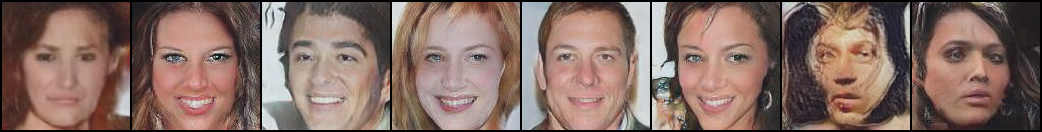

In [21]:
IPython.display.display(Image.fromarray(image_grid_np))

### Transformation

In [0]:
class AUTransform:
  def __init__(self, n):
    self.aun = n
    self.Nsliders = 1
    self.num_aus = 17
    
  def get_target_np(self, outputs_zs, alpha):
    ''' return target image and mask and number of nonzero elements in mask '''
    t1 = np.zeros(shape=(batch_size, self.num_aus))
    t1[:, self.aun] = alpha * np.ones(shape=(batch_size,))
    return t1

  def get_train_alpha(self, batch_size):
    ''' get an alpha for training, return in format
    alpha_val_for_graph, alpha_val_for_get_target_np'''
    alpha_val = np.random.uniform(0, 1)
    # alpha_val = np.zeros(shape=(batch_size, self.num_aus))
    # alpha_val[self.aun, :] = np.random.random(size=(1, self.num_aus))    
    # alpha_val = np.zeros(shape=(batch_size, self.Nsliders))
    slider = np.ones((batch_size, self.Nsliders)) * alpha_val
    return slider, alpha_val

  def scale_test_alpha_for_graph(self, alpha, batch_size):
    ''' map a scalar alpha to the appropriate shape,
      and do the desired transformation '''
    slider = alpha * np.ones((batch_size, self.Nsliders))
    return slider
  
  def vis_alphas(self, num_panels=7, alpha_min=0, alpha_max=1):
    return np.linspace(alpha_min, alpha_max, num_panels)

In [0]:
class EmotionTransform:
  def __init__(self):
    self.Nsliders = 17
    self.num_aus = 17
    
  def get_target_np(self, outputs_zs, alpha):
    ''' return target image and mask and number of nonzero elements in mask '''
    return np.random.random(size=(batch_size, self.num_aus))

  def get_train_alpha(self, batch_size):
    ''' get an alpha for training, return in format
    alpha_val_for_graph, alpha_val_for_get_target_np'''
    alpha_val = np.random.random(size=(batch_size, self.num_aus))
    slider = np.ones((batch_size, self.Nsliders)) * alpha_val
    return slider, alpha_val

  def scale_test_alpha_for_graph(self, alpha, batch_size):
    ''' map a scalar alpha to the appropriate shape,
      and do the desired transformation '''
    slider = alpha * np.ones((batch_size, self.Nsliders))
    return slider
  
  def vis_alphas(self, num_panels=7, alpha_min=0, alpha_max=1):
    return np.linspace(alpha_min, alpha_max, num_panels)

In [0]:
# transform = EmotionTransform()

transform = AUTransform(n=6)

### Training

#### Hyperparameters

In [0]:
# training parameters
dim_z = z_.shape[1]
learning_rate = 0.001 # you can also try changing this as well
num_samples = 4000
n_epoch = 1
save_freq = 400 # frequency to save weights

In [0]:
# initialize a variable for the walk with mean 0 and standard deviation 0.1
w = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z, transform.Nsliders]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)

In [0]:
# loss function and optimizer
criterion = nn.MSELoss(reduction='sum').to(device)
optimizer = optim.Adam([w], lr=learning_rate)

In [223]:
loss_sum = 0;
optim_iter = 0
batch_size = G_batch_size
loss_values = []

# train loop
for batch_num in range(num_samples // batch_size):#num_samples // batch_size
  start_time = time.time()
  
  # 1. sample z and y randomly
  # fill in your code here
  z_, _ = G.buildNoiseData(G_batch_size)
    
  # sample alpha
  alpha_for_graph, alpha_for_target = transform.get_train_alpha(batch_size)
  alpha_tensor = torch.tensor(alpha_for_graph, device='cuda', dtype=torch.float32)

  with torch.no_grad():
    # 2. do a forward pass to get model outputs: out_im
    # fill in your code here
    # out_im = G.test(z_)
    out_im = netG.forward(z_)
    feature1 = net(out_im)[0]

    
  # get target and mask
  target_fn = transform.get_target_np(out_im.cpu().numpy(), alpha_for_target)
  target_tensor = torch.tensor(target_fn, device='cuda', dtype=torch.float32)
  
  # forward pass
  optimizer.zero_grad()
  z_new = z_ 
  for i in range(transform.Nsliders):
    # 3. for each slider, add alpha * w to z_, you may need to check dimensions
    # fill in your code here 
    z_new = z_new + alpha_tensor[:,i].unsqueeze(1) * w[:,:,i]
    # there are also other ways you could do this
    
  out_im = netG.forward(z_new)#.to(device)
  feature2 = net(out_im)[0]
  # mean over unmasked regions in the target
  loss1 = criterion(model(out_im), target_tensor)
  loss2 = criterion(feature1, feature2)
#   print("-----")
#   print(loss1.item(), loss2.item())
#   print("-----")
#   loss = criterion(model(out_im), target_tensor) + criterion(feature1, feature2)
  loss = 0.4 * loss1 + 0.6 * loss2
  
  # 4. optimize loss 
  # fill in your code here 
  loss.backward()
  optimizer.step()
  
  loss_values.append(loss)
  loss_sum += loss
  elapsed_time = time.time() - start_time
  
  if (optim_iter % save_freq == 0) and (optim_iter > 0):
    print('T, bst, lss, a: {}, {}, {}, {}'.format(elapsed_time, batch_num * batch_size, loss, alpha_for_target))
 
  # save intermediate walk
  if (optim_iter % save_freq == 0) and (optim_iter > 0):
    torch.save(w, 'w_{}.pth'.format(optim_iter * batch_size))
  
  optim_iter += 1
  
print('average loss with this metric: ', loss_sum/(optim_iter*batch_size))
torch.save(w, 'w_final.pth')

T, bst, lss, a: 0.8275887966156006, 3200, 3.2821226119995117, 0.9277742311499063
average loss with this metric:  tensor(0.1957, device='cuda:0', grad_fn=<DivBackward0>)


In [0]:
!cp 'w_final.pth' 'drive/My Drive/two_au_.pth'

In [0]:
#@title Generate test samples { display-mode: "form", run: "auto" }

num_samples = 15 #@param {type:"slider", min:1, max:20, step:1}
noise_seed = 84 #@param {type:"slider", min:0, max:100, step:1}
# category = "620) laptop, laptop computer" #@param ["0) tench, Tinca tinca", "1) goldfish, Carassius auratus", "2) great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias", "3) tiger shark, Galeocerdo cuvieri", "4) hammerhead, hammerhead shark", "5) electric ray, crampfish, numbfish, torpedo", "6) stingray", "7) cock", "8) hen", "9) ostrich, Struthio camelus", "10) brambling, Fringilla montifringilla", "11) goldfinch, Carduelis carduelis", "12) house finch, linnet, Carpodacus mexicanus", "13) junco, snowbird", "14) indigo bunting, indigo finch, indigo bird, Passerina cyanea", "15) robin, American robin, Turdus migratorius", "16) bulbul", "17) jay", "18) magpie", "19) chickadee", "20) water ouzel, dipper", "21) kite", "22) bald eagle, American eagle, Haliaeetus leucocephalus", "23) vulture", "24) great grey owl, great gray owl, Strix nebulosa", "25) European fire salamander, Salamandra salamandra", "26) common newt, Triturus vulgaris", "27) eft", "28) spotted salamander, Ambystoma maculatum", "29) axolotl, mud puppy, Ambystoma mexicanum", "30) bullfrog, Rana catesbeiana", "31) tree frog, tree-frog", "32) tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui", "33) loggerhead, loggerhead turtle, Caretta caretta", "34) leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea", "35) mud turtle", "36) terrapin", "37) box turtle, box tortoise", "38) banded gecko", "39) common iguana, iguana, Iguana iguana", "40) American chameleon, anole, Anolis carolinensis", "41) whiptail, whiptail lizard", "42) agama", "43) frilled lizard, Chlamydosaurus kingi", "44) alligator lizard", "45) Gila monster, Heloderma suspectum", "46) green lizard, Lacerta viridis", "47) African chameleon, Chamaeleo chamaeleon", "48) Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis", "49) African crocodile, Nile crocodile, Crocodylus niloticus", "50) American alligator, Alligator mississipiensis", "51) triceratops", "52) thunder snake, worm snake, Carphophis amoenus", "53) ringneck snake, ring-necked snake, ring snake", "54) hognose snake, puff adder, sand viper", "55) green snake, grass snake", "56) king snake, kingsnake", "57) garter snake, grass snake", "58) water snake", "59) vine snake", "60) night snake, Hypsiglena torquata", "61) boa constrictor, Constrictor constrictor", "62) rock python, rock snake, Python sebae", "63) Indian cobra, Naja naja", "64) green mamba", "65) sea snake", "66) horned viper, cerastes, sand viper, horned asp, Cerastes cornutus", "67) diamondback, diamondback rattlesnake, Crotalus adamanteus", "68) sidewinder, horned rattlesnake, Crotalus cerastes", "69) trilobite", "70) harvestman, daddy longlegs, Phalangium opilio", "71) scorpion", "72) black and gold garden spider, Argiope aurantia", "73) barn spider, Araneus cavaticus", "74) garden spider, Aranea diademata", "75) black widow, Latrodectus mactans", "76) tarantula", "77) wolf spider, hunting spider", "78) tick", "79) centipede", "80) black grouse", "81) ptarmigan", "82) ruffed grouse, partridge, Bonasa umbellus", "83) prairie chicken, prairie grouse, prairie fowl", "84) peacock", "85) quail", "86) partridge", "87) African grey, African gray, Psittacus erithacus", "88) macaw", "89) sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita", "90) lorikeet", "91) coucal", "92) bee eater", "93) hornbill", "94) hummingbird", "95) jacamar", "96) toucan", "97) drake", "98) red-breasted merganser, Mergus serrator", "99) goose", "100) black swan, Cygnus atratus", "101) tusker", "102) echidna, spiny anteater, anteater", "103) platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus", "104) wallaby, brush kangaroo", "105) koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus", "106) wombat", "107) jellyfish", "108) sea anemone, anemone", "109) brain coral", "110) flatworm, platyhelminth", "111) nematode, nematode worm, roundworm", "112) conch", "113) snail", "114) slug", "115) sea slug, nudibranch", "116) chiton, coat-of-mail shell, sea cradle, polyplacophore", "117) chambered nautilus, pearly nautilus, nautilus", "118) Dungeness crab, Cancer magister", "119) rock crab, Cancer irroratus", "120) fiddler crab", "121) king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica", "122) American lobster, Northern lobster, Maine lobster, Homarus americanus", "123) spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish", "124) crayfish, crawfish, crawdad, crawdaddy", "125) hermit crab", "126) isopod", "127) white stork, Ciconia ciconia", "128) black stork, Ciconia nigra", "129) spoonbill", "130) flamingo", "131) little blue heron, Egretta caerulea", "132) American egret, great white heron, Egretta albus", "133) bittern", "134) crane", "135) limpkin, Aramus pictus", "136) European gallinule, Porphyrio porphyrio", "137) American coot, marsh hen, mud hen, water hen, Fulica americana", "138) bustard", "139) ruddy turnstone, Arenaria interpres", "140) red-backed sandpiper, dunlin, Erolia alpina", "141) redshank, Tringa totanus", "142) dowitcher", "143) oystercatcher, oyster catcher", "144) pelican", "145) king penguin, Aptenodytes patagonica", "146) albatross, mollymawk", "147) grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus", "148) killer whale, killer, orca, grampus, sea wolf, Orcinus orca", "149) dugong, Dugong dugon", "150) sea lion", "151) Chihuahua", "152) Japanese spaniel", "153) Maltese dog, Maltese terrier, Maltese", "154) Pekinese, Pekingese, Peke", "155) Shih-Tzu", "156) Blenheim spaniel", "157) papillon", "158) toy terrier", "159) Rhodesian ridgeback", "160) Afghan hound, Afghan", "161) basset, basset hound", "162) beagle", "163) bloodhound, sleuthhound", "164) bluetick", "165) black-and-tan coonhound", "166) Walker hound, Walker foxhound", "167) English foxhound", "168) redbone", "169) borzoi, Russian wolfhound", "170) Irish wolfhound", "171) Italian greyhound", "172) whippet", "173) Ibizan hound, Ibizan Podenco", "174) Norwegian elkhound, elkhound", "175) otterhound, otter hound", "176) Saluki, gazelle hound", "177) Scottish deerhound, deerhound", "178) Weimaraner", "179) Staffordshire bullterrier, Staffordshire bull terrier", "180) American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier", "181) Bedlington terrier", "182) Border terrier", "183) Kerry blue terrier", "184) Irish terrier", "185) Norfolk terrier", "186) Norwich terrier", "187) Yorkshire terrier", "188) wire-haired fox terrier", "189) Lakeland terrier", "190) Sealyham terrier, Sealyham", "191) Airedale, Airedale terrier", "192) cairn, cairn terrier", "193) Australian terrier", "194) Dandie Dinmont, Dandie Dinmont terrier", "195) Boston bull, Boston terrier", "196) miniature schnauzer", "197) giant schnauzer", "198) standard schnauzer", "199) Scotch terrier, Scottish terrier, Scottie", "200) Tibetan terrier, chrysanthemum dog", "201) silky terrier, Sydney silky", "202) soft-coated wheaten terrier", "203) West Highland white terrier", "204) Lhasa, Lhasa apso", "205) flat-coated retriever", "206) curly-coated retriever", "207) golden retriever", "208) Labrador retriever", "209) Chesapeake Bay retriever", "210) German short-haired pointer", "211) vizsla, Hungarian pointer", "212) English setter", "213) Irish setter, red setter", "214) Gordon setter", "215) Brittany spaniel", "216) clumber, clumber spaniel", "217) English springer, English springer spaniel", "218) Welsh springer spaniel", "219) cocker spaniel, English cocker spaniel, cocker", "220) Sussex spaniel", "221) Irish water spaniel", "222) kuvasz", "223) schipperke", "224) groenendael", "225) malinois", "226) briard", "227) kelpie", "228) komondor", "229) Old English sheepdog, bobtail", "230) Shetland sheepdog, Shetland sheep dog, Shetland", "231) collie", "232) Border collie", "233) Bouvier des Flandres, Bouviers des Flandres", "234) Rottweiler", "235) German shepherd, German shepherd dog, German police dog, alsatian", "236) Doberman, Doberman pinscher", "237) miniature pinscher", "238) Greater Swiss Mountain dog", "239) Bernese mountain dog", "240) Appenzeller", "241) EntleBucher", "242) boxer", "243) bull mastiff", "244) Tibetan mastiff", "245) French bulldog", "246) Great Dane", "247) Saint Bernard, St Bernard", "248) Eskimo dog, husky", "249) malamute, malemute, Alaskan malamute", "250) Siberian husky", "251) dalmatian, coach dog, carriage dog", "252) affenpinscher, monkey pinscher, monkey dog", "253) basenji", "254) pug, pug-dog", "255) Leonberg", "256) Newfoundland, Newfoundland dog", "257) Great Pyrenees", "258) Samoyed, Samoyede", "259) Pomeranian", "260) chow, chow chow", "261) keeshond", "262) Brabancon griffon", "263) Pembroke, Pembroke Welsh corgi", "264) Cardigan, Cardigan Welsh corgi", "265) toy poodle", "266) miniature poodle", "267) standard poodle", "268) Mexican hairless", "269) timber wolf, grey wolf, gray wolf, Canis lupus", "270) white wolf, Arctic wolf, Canis lupus tundrarum", "271) red wolf, maned wolf, Canis rufus, Canis niger", "272) coyote, prairie wolf, brush wolf, Canis latrans", "273) dingo, warrigal, warragal, Canis dingo", "274) dhole, Cuon alpinus", "275) African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus", "276) hyena, hyaena", "277) red fox, Vulpes vulpes", "278) kit fox, Vulpes macrotis", "279) Arctic fox, white fox, Alopex lagopus", "280) grey fox, gray fox, Urocyon cinereoargenteus", "281) tabby, tabby cat", "282) tiger cat", "283) Persian cat", "284) Siamese cat, Siamese", "285) Egyptian cat", "286) cougar, puma, catamount, mountain lion, painter, panther, Felis concolor", "287) lynx, catamount", "288) leopard, Panthera pardus", "289) snow leopard, ounce, Panthera uncia", "290) jaguar, panther, Panthera onca, Felis onca", "291) lion, king of beasts, Panthera leo", "292) tiger, Panthera tigris", "293) cheetah, chetah, Acinonyx jubatus", "294) brown bear, bruin, Ursus arctos", "295) American black bear, black bear, Ursus americanus, Euarctos americanus", "296) ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus", "297) sloth bear, Melursus ursinus, Ursus ursinus", "298) mongoose", "299) meerkat, mierkat", "300) tiger beetle", "301) ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle", "302) ground beetle, carabid beetle", "303) long-horned beetle, longicorn, longicorn beetle", "304) leaf beetle, chrysomelid", "305) dung beetle", "306) rhinoceros beetle", "307) weevil", "308) fly", "309) bee", "310) ant, emmet, pismire", "311) grasshopper, hopper", "312) cricket", "313) walking stick, walkingstick, stick insect", "314) cockroach, roach", "315) mantis, mantid", "316) cicada, cicala", "317) leafhopper", "318) lacewing, lacewing fly", "319) dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", "320) damselfly", "321) admiral", "322) ringlet, ringlet butterfly", "323) monarch, monarch butterfly, milkweed butterfly, Danaus plexippus", "324) cabbage butterfly", "325) sulphur butterfly, sulfur butterfly", "326) lycaenid, lycaenid butterfly", "327) starfish, sea star", "328) sea urchin", "329) sea cucumber, holothurian", "330) wood rabbit, cottontail, cottontail rabbit", "331) hare", "332) Angora, Angora rabbit", "333) hamster", "334) porcupine, hedgehog", "335) fox squirrel, eastern fox squirrel, Sciurus niger", "336) marmot", "337) beaver", "338) guinea pig, Cavia cobaya", "339) sorrel", "340) zebra", "341) hog, pig, grunter, squealer, Sus scrofa", "342) wild boar, boar, Sus scrofa", "343) warthog", "344) hippopotamus, hippo, river horse, Hippopotamus amphibius", "345) ox", "346) water buffalo, water ox, Asiatic buffalo, Bubalus bubalis", "347) bison", "348) ram, tup", "349) bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis", "350) ibex, Capra ibex", "351) hartebeest", "352) impala, Aepyceros melampus", "353) gazelle", "354) Arabian camel, dromedary, Camelus dromedarius", "355) llama", "356) weasel", "357) mink", "358) polecat, fitch, foulmart, foumart, Mustela putorius", "359) black-footed ferret, ferret, Mustela nigripes", "360) otter", "361) skunk, polecat, wood pussy", "362) badger", "363) armadillo", "364) three-toed sloth, ai, Bradypus tridactylus", "365) orangutan, orang, orangutang, Pongo pygmaeus", "366) gorilla, Gorilla gorilla", "367) chimpanzee, chimp, Pan troglodytes", "368) gibbon, Hylobates lar", "369) siamang, Hylobates syndactylus, Symphalangus syndactylus", "370) guenon, guenon monkey", "371) patas, hussar monkey, Erythrocebus patas", "372) baboon", "373) macaque", "374) langur", "375) colobus, colobus monkey", "376) proboscis monkey, Nasalis larvatus", "377) marmoset", "378) capuchin, ringtail, Cebus capucinus", "379) howler monkey, howler", "380) titi, titi monkey", "381) spider monkey, Ateles geoffroyi", "382) squirrel monkey, Saimiri sciureus", "383) Madagascar cat, ring-tailed lemur, Lemur catta", "384) indri, indris, Indri indri, Indri brevicaudatus", "385) Indian elephant, Elephas maximus", "386) African elephant, Loxodonta africana", "387) lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens", "388) giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca", "389) barracouta, snoek", "390) eel", "391) coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch", "392) rock beauty, Holocanthus tricolor", "393) anemone fish", "394) sturgeon", "395) gar, garfish, garpike, billfish, Lepisosteus osseus", "396) lionfish", "397) puffer, pufferfish, blowfish, globefish", "398) abacus", "399) abaya", "400) academic gown, academic robe, judge's robe", "401) accordion, piano accordion, squeeze box", "402) acoustic guitar", "403) aircraft carrier, carrier, flattop, attack aircraft carrier", "404) airliner", "405) airship, dirigible", "406) altar", "407) ambulance", "408) amphibian, amphibious vehicle", "409) analog clock", "410) apiary, bee house", "411) apron", "412) ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin", "413) assault rifle, assault gun", "414) backpack, back pack, knapsack, packsack, rucksack, haversack", "415) bakery, bakeshop, bakehouse", "416) balance beam, beam", "417) balloon", "418) ballpoint, ballpoint pen, ballpen, Biro", "419) Band Aid", "420) banjo", "421) bannister, banister, balustrade, balusters, handrail", "422) barbell", "423) barber chair", "424) barbershop", "425) barn", "426) barometer", "427) barrel, cask", "428) barrow, garden cart, lawn cart, wheelbarrow", "429) baseball", "430) basketball", "431) bassinet", "432) bassoon", "433) bathing cap, swimming cap", "434) bath towel", "435) bathtub, bathing tub, bath, tub", "436) beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon", "437) beacon, lighthouse, beacon light, pharos", "438) beaker", "439) bearskin, busby, shako", "440) beer bottle", "441) beer glass", "442) bell cote, bell cot", "443) bib", "444) bicycle-built-for-two, tandem bicycle, tandem", "445) bikini, two-piece", "446) binder, ring-binder", "447) binoculars, field glasses, opera glasses", "448) birdhouse", "449) boathouse", "450) bobsled, bobsleigh, bob", "451) bolo tie, bolo, bola tie, bola", "452) bonnet, poke bonnet", "453) bookcase", "454) bookshop, bookstore, bookstall", "455) bottlecap", "456) bow", "457) bow tie, bow-tie, bowtie", "458) brass, memorial tablet, plaque", "459) brassiere, bra, bandeau", "460) breakwater, groin, groyne, mole, bulwark, seawall, jetty", "461) breastplate, aegis, egis", "462) broom", "463) bucket, pail", "464) buckle", "465) bulletproof vest", "466) bullet train, bullet", "467) butcher shop, meat market", "468) cab, hack, taxi, taxicab", "469) caldron, cauldron", "470) candle, taper, wax light", "471) cannon", "472) canoe", "473) can opener, tin opener", "474) cardigan", "475) car mirror", "476) carousel, carrousel, merry-go-round, roundabout, whirligig", "477) carpenter's kit, tool kit", "478) carton", "479) car wheel", "480) cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM", "481) cassette", "482) cassette player", "483) castle", "484) catamaran", "485) CD player", "486) cello, violoncello", "487) cellular telephone, cellular phone, cellphone, cell, mobile phone", "488) chain", "489) chainlink fence", "490) chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour", "491) chain saw, chainsaw", "492) chest", "493) chiffonier, commode", "494) chime, bell, gong", "495) china cabinet, china closet", "496) Christmas stocking", "497) church, church building", "498) cinema, movie theater, movie theatre, movie house, picture palace", "499) cleaver, meat cleaver, chopper", "500) cliff dwelling", "501) cloak", "502) clog, geta, patten, sabot", "503) cocktail shaker", "504) coffee mug", "505) coffeepot", "506) coil, spiral, volute, whorl, helix", "507) combination lock", "508) computer keyboard, keypad", "509) confectionery, confectionary, candy store", "510) container ship, containership, container vessel", "511) convertible", "512) corkscrew, bottle screw", "513) cornet, horn, trumpet, trump", "514) cowboy boot", "515) cowboy hat, ten-gallon hat", "516) cradle", "517) crane", "518) crash helmet", "519) crate", "520) crib, cot", "521) Crock Pot", "522) croquet ball", "523) crutch", "524) cuirass", "525) dam, dike, dyke", "526) desk", "527) desktop computer", "528) dial telephone, dial phone", "529) diaper, nappy, napkin", "530) digital clock", "531) digital watch", "532) dining table, board", "533) dishrag, dishcloth", "534) dishwasher, dish washer, dishwashing machine", "535) disk brake, disc brake", "536) dock, dockage, docking facility", "537) dogsled, dog sled, dog sleigh", "538) dome", "539) doormat, welcome mat", "540) drilling platform, offshore rig", "541) drum, membranophone, tympan", "542) drumstick", "543) dumbbell", "544) Dutch oven", "545) electric fan, blower", "546) electric guitar", "547) electric locomotive", "548) entertainment center", "549) envelope", "550) espresso maker", "551) face powder", "552) feather boa, boa", "553) file, file cabinet, filing cabinet", "554) fireboat", "555) fire engine, fire truck", "556) fire screen, fireguard", "557) flagpole, flagstaff", "558) flute, transverse flute", "559) folding chair", "560) football helmet", "561) forklift", "562) fountain", "563) fountain pen", "564) four-poster", "565) freight car", "566) French horn, horn", "567) frying pan, frypan, skillet", "568) fur coat", "569) garbage truck, dustcart", "570) gasmask, respirator, gas helmet", "571) gas pump, gasoline pump, petrol pump, island dispenser", "572) goblet", "573) go-kart", "574) golf ball", "575) golfcart, golf cart", "576) gondola", "577) gong, tam-tam", "578) gown", "579) grand piano, grand", "580) greenhouse, nursery, glasshouse", "581) grille, radiator grille", "582) grocery store, grocery, food market, market", "583) guillotine", "584) hair slide", "585) hair spray", "586) half track", "587) hammer", "588) hamper", "589) hand blower, blow dryer, blow drier, hair dryer, hair drier", "590) hand-held computer, hand-held microcomputer", "591) handkerchief, hankie, hanky, hankey", "592) hard disc, hard disk, fixed disk", "593) harmonica, mouth organ, harp, mouth harp", "594) harp", "595) harvester, reaper", "596) hatchet", "597) holster", "598) home theater, home theatre", "599) honeycomb", "600) hook, claw", "601) hoopskirt, crinoline", "602) horizontal bar, high bar", "603) horse cart, horse-cart", "604) hourglass", "605) iPod", "606) iron, smoothing iron", "607) jack-o'-lantern", "608) jean, blue jean, denim", "609) jeep, landrover", "610) jersey, T-shirt, tee shirt", "611) jigsaw puzzle", "612) jinrikisha, ricksha, rickshaw", "613) joystick", "614) kimono", "615) knee pad", "616) knot", "617) lab coat, laboratory coat", "618) ladle", "619) lampshade, lamp shade", "620) laptop, laptop computer", "621) lawn mower, mower", "622) lens cap, lens cover", "623) letter opener, paper knife, paperknife", "624) library", "625) lifeboat", "626) lighter, light, igniter, ignitor", "627) limousine, limo", "628) liner, ocean liner", "629) lipstick, lip rouge", "630) Loafer", "631) lotion", "632) loudspeaker, speaker, speaker unit, loudspeaker system, speaker system", "633) loupe, jeweler's loupe", "634) lumbermill, sawmill", "635) magnetic compass", "636) mailbag, postbag", "637) mailbox, letter box", "638) maillot", "639) maillot, tank suit", "640) manhole cover", "641) maraca", "642) marimba, xylophone", "643) mask", "644) matchstick", "645) maypole", "646) maze, labyrinth", "647) measuring cup", "648) medicine chest, medicine cabinet", "649) megalith, megalithic structure", "650) microphone, mike", "651) microwave, microwave oven", "652) military uniform", "653) milk can", "654) minibus", "655) miniskirt, mini", "656) minivan", "657) missile", "658) mitten", "659) mixing bowl", "660) mobile home, manufactured home", "661) Model T", "662) modem", "663) monastery", "664) monitor", "665) moped", "666) mortar", "667) mortarboard", "668) mosque", "669) mosquito net", "670) motor scooter, scooter", "671) mountain bike, all-terrain bike, off-roader", "672) mountain tent", "673) mouse, computer mouse", "674) mousetrap", "675) moving van", "676) muzzle", "677) nail", "678) neck brace", "679) necklace", "680) nipple", "681) notebook, notebook computer", "682) obelisk", "683) oboe, hautboy, hautbois", "684) ocarina, sweet potato", "685) odometer, hodometer, mileometer, milometer", "686) oil filter", "687) organ, pipe organ", "688) oscilloscope, scope, cathode-ray oscilloscope, CRO", "689) overskirt", "690) oxcart", "691) oxygen mask", "692) packet", "693) paddle, boat paddle", "694) paddlewheel, paddle wheel", "695) padlock", "696) paintbrush", "697) pajama, pyjama, pj's, jammies", "698) palace", "699) panpipe, pandean pipe, syrinx", "700) paper towel", "701) parachute, chute", "702) parallel bars, bars", "703) park bench", "704) parking meter", "705) passenger car, coach, carriage", "706) patio, terrace", "707) pay-phone, pay-station", "708) pedestal, plinth, footstall", "709) pencil box, pencil case", "710) pencil sharpener", "711) perfume, essence", "712) Petri dish", "713) photocopier", "714) pick, plectrum, plectron", "715) pickelhaube", "716) picket fence, paling", "717) pickup, pickup truck", "718) pier", "719) piggy bank, penny bank", "720) pill bottle", "721) pillow", "722) ping-pong ball", "723) pinwheel", "724) pirate, pirate ship", "725) pitcher, ewer", "726) plane, carpenter's plane, woodworking plane", "727) planetarium", "728) plastic bag", "729) plate rack", "730) plow, plough", "731) plunger, plumber's helper", "732) Polaroid camera, Polaroid Land camera", "733) pole", "734) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria", "735) poncho", "736) pool table, billiard table, snooker table", "737) pop bottle, soda bottle", "738) pot, flowerpot", "739) potter's wheel", "740) power drill", "741) prayer rug, prayer mat", "742) printer", "743) prison, prison house", "744) projectile, missile", "745) projector", "746) puck, hockey puck", "747) punching bag, punch bag, punching ball, punchball", "748) purse", "749) quill, quill pen", "750) quilt, comforter, comfort, puff", "751) racer, race car, racing car", "752) racket, racquet", "753) radiator", "754) radio, wireless", "755) radio telescope, radio reflector", "756) rain barrel", "757) recreational vehicle, RV, R.V.", "758) reel", "759) reflex camera", "760) refrigerator, icebox", "761) remote control, remote", "762) restaurant, eating house, eating place, eatery", "763) revolver, six-gun, six-shooter", "764) rifle", "765) rocking chair, rocker", "766) rotisserie", "767) rubber eraser, rubber, pencil eraser", "768) rugby ball", "769) rule, ruler", "770) running shoe", "771) safe", "772) safety pin", "773) saltshaker, salt shaker", "774) sandal", "775) sarong", "776) sax, saxophone", "777) scabbard", "778) scale, weighing machine", "779) school bus", "780) schooner", "781) scoreboard", "782) screen, CRT screen", "783) screw", "784) screwdriver", "785) seat belt, seatbelt", "786) sewing machine", "787) shield, buckler", "788) shoe shop, shoe-shop, shoe store", "789) shoji", "790) shopping basket", "791) shopping cart", "792) shovel", "793) shower cap", "794) shower curtain", "795) ski", "796) ski mask", "797) sleeping bag", "798) slide rule, slipstick", "799) sliding door", "800) slot, one-armed bandit", "801) snorkel", "802) snowmobile", "803) snowplow, snowplough", "804) soap dispenser", "805) soccer ball", "806) sock", "807) solar dish, solar collector, solar furnace", "808) sombrero", "809) soup bowl", "810) space bar", "811) space heater", "812) space shuttle", "813) spatula", "814) speedboat", "815) spider web, spider's web", "816) spindle", "817) sports car, sport car", "818) spotlight, spot", "819) stage", "820) steam locomotive", "821) steel arch bridge", "822) steel drum", "823) stethoscope", "824) stole", "825) stone wall", "826) stopwatch, stop watch", "827) stove", "828) strainer", "829) streetcar, tram, tramcar, trolley, trolley car", "830) stretcher", "831) studio couch, day bed", "832) stupa, tope", "833) submarine, pigboat, sub, U-boat", "834) suit, suit of clothes", "835) sundial", "836) sunglass", "837) sunglasses, dark glasses, shades", "838) sunscreen, sunblock, sun blocker", "839) suspension bridge", "840) swab, swob, mop", "841) sweatshirt", "842) swimming trunks, bathing trunks", "843) swing", "844) switch, electric switch, electrical switch", "845) syringe", "846) table lamp", "847) tank, army tank, armored combat vehicle, armoured combat vehicle", "848) tape player", "849) teapot", "850) teddy, teddy bear", "851) television, television system", "852) tennis ball", "853) thatch, thatched roof", "854) theater curtain, theatre curtain", "855) thimble", "856) thresher, thrasher, threshing machine", "857) throne", "858) tile roof", "859) toaster", "860) tobacco shop, tobacconist shop, tobacconist", "861) toilet seat", "862) torch", "863) totem pole", "864) tow truck, tow car, wrecker", "865) toyshop", "866) tractor", "867) trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi", "868) tray", "869) trench coat", "870) tricycle, trike, velocipede", "871) trimaran", "872) tripod", "873) triumphal arch", "874) trolleybus, trolley coach, trackless trolley", "875) trombone", "876) tub, vat", "877) turnstile", "878) typewriter keyboard", "879) umbrella", "880) unicycle, monocycle", "881) upright, upright piano", "882) vacuum, vacuum cleaner", "883) vase", "884) vault", "885) velvet", "886) vending machine", "887) vestment", "888) viaduct", "889) violin, fiddle", "890) volleyball", "891) waffle iron", "892) wall clock", "893) wallet, billfold, notecase, pocketbook", "894) wardrobe, closet, press", "895) warplane, military plane", "896) washbasin, handbasin, washbowl, lavabo, wash-hand basin", "897) washer, automatic washer, washing machine", "898) water bottle", "899) water jug", "900) water tower", "901) whiskey jug", "902) whistle", "903) wig", "904) window screen", "905) window shade", "906) Windsor tie", "907) wine bottle", "908) wing", "909) wok", "910) wooden spoon", "911) wool, woolen, woollen", "912) worm fence, snake fence, snake-rail fence, Virginia fence", "913) wreck", "914) yawl", "915) yurt", "916) web site, website, internet site, site", "917) comic book", "918) crossword puzzle, crossword", "919) street sign", "920) traffic light, traffic signal, stoplight", "921) book jacket, dust cover, dust jacket, dust wrapper", "922) menu", "923) plate", "924) guacamole", "925) consomme", "926) hot pot, hotpot", "927) trifle", "928) ice cream, icecream", "929) ice lolly, lolly, lollipop, popsicle", "930) French loaf", "931) bagel, beigel", "932) pretzel", "933) cheeseburger", "934) hotdog, hot dog, red hot", "935) mashed potato", "936) head cabbage", "937) broccoli", "938) cauliflower", "939) zucchini, courgette", "940) spaghetti squash", "941) acorn squash", "942) butternut squash", "943) cucumber, cuke", "944) artichoke, globe artichoke", "945) bell pepper", "946) cardoon", "947) mushroom", "948) Granny Smith", "949) strawberry", "950) orange", "951) lemon", "952) fig", "953) pineapple, ananas", "954) banana", "955) jackfruit, jak, jack", "956) custard apple", "957) pomegranate", "958) hay", "959) carbonara", "960) chocolate sauce, chocolate syrup", "961) dough", "962) meat loaf, meatloaf", "963) pizza, pizza pie", "964) potpie", "965) burrito", "966) red wine", "967) espresso", "968) cup", "969) eggnog", "970) alp", "971) bubble", "972) cliff, drop, drop-off", "973) coral reef", "974) geyser", "975) lakeside, lakeshore", "976) promontory, headland, head, foreland", "977) sandbar, sand bar", "978) seashore, coast, seacoast, sea-coast", "979) valley, vale", "980) volcano", "981) ballplayer, baseball player", "982) groom, bridegroom", "983) scuba diver", "984) rapeseed", "985) daisy", "986) yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum", "987) corn", "988) acorn", "989) hip, rose hip, rosehip", "990) buckeye, horse chestnut, conker", "991) coral fungus", "992) agaric", "993) gyromitra", "994) stinkhorn, carrion fungus", "995) earthstar", "996) hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa", "997) bolete", "998) ear, spike, capitulum", "999) toilet tissue, toilet paper, bathroom tissue"]


torch.manual_seed(noise_seed)
z, _ = G.buildNoiseData(num_samples)

In [273]:
for batch_num in range(num_samples):
  z_batch = z[[batch_num], :]
  
  ims = []
  
  alphas = 5 * transform.vis_alphas(num_panels=10) - 10
  print(alphas)
  
  for i in range(alphas.shape[0]):
    
    alpha_for_graph = transform.scale_test_alpha_for_graph(alphas[i], 1) # , channel=0) # can add channel for color
    alpha_tensor = torch.tensor(alpha_for_graph, device='cuda', dtype=torch.float32)
    
    with torch.no_grad():
      z_new = z_batch
      for i in range(transform.Nsliders):
        z_new = z_new + alpha_tensor[:,i].unsqueeze(1) * w[:,:,i]
      out_im = netG.forward(z_new)
    ims.append(out_im) 
    
  image_grid = torchvision.utils.make_grid(
    torch.cat(ims),
    nrow=len(alphas),
    normalize=True,
  )
  image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
  image_grid_np = np.uint8(image_grid_np)
  IPython.display.display(Image.fromarray(image_grid_np))

Output hidden; open in https://colab.research.google.com to view.

In [90]:
alpha_tensor

tensor([[1.]], device='cuda:0')

In [0]:
#@title Generate test samples { display-mode: "form", run: "auto" }

num_samples = 1 #@param {type:"slider", min:1, max:20, step:1}
noise_seed = 90 #@param {type:"slider", min:0, max:100, step:1}
# category = "620) laptop, laptop computer" #@param ["0) tench, Tinca tinca", "1) goldfish, Carassius auratus", "2) great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias", "3) tiger shark, Galeocerdo cuvieri", "4) hammerhead, hammerhead shark", "5) electric ray, crampfish, numbfish, torpedo", "6) stingray", "7) cock", "8) hen", "9) ostrich, Struthio camelus", "10) brambling, Fringilla montifringilla", "11) goldfinch, Carduelis carduelis", "12) house finch, linnet, Carpodacus mexicanus", "13) junco, snowbird", "14) indigo bunting, indigo finch, indigo bird, Passerina cyanea", "15) robin, American robin, Turdus migratorius", "16) bulbul", "17) jay", "18) magpie", "19) chickadee", "20) water ouzel, dipper", "21) kite", "22) bald eagle, American eagle, Haliaeetus leucocephalus", "23) vulture", "24) great grey owl, great gray owl, Strix nebulosa", "25) European fire salamander, Salamandra salamandra", "26) common newt, Triturus vulgaris", "27) eft", "28) spotted salamander, Ambystoma maculatum", "29) axolotl, mud puppy, Ambystoma mexicanum", "30) bullfrog, Rana catesbeiana", "31) tree frog, tree-frog", "32) tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui", "33) loggerhead, loggerhead turtle, Caretta caretta", "34) leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea", "35) mud turtle", "36) terrapin", "37) box turtle, box tortoise", "38) banded gecko", "39) common iguana, iguana, Iguana iguana", "40) American chameleon, anole, Anolis carolinensis", "41) whiptail, whiptail lizard", "42) agama", "43) frilled lizard, Chlamydosaurus kingi", "44) alligator lizard", "45) Gila monster, Heloderma suspectum", "46) green lizard, Lacerta viridis", "47) African chameleon, Chamaeleo chamaeleon", "48) Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis", "49) African crocodile, Nile crocodile, Crocodylus niloticus", "50) American alligator, Alligator mississipiensis", "51) triceratops", "52) thunder snake, worm snake, Carphophis amoenus", "53) ringneck snake, ring-necked snake, ring snake", "54) hognose snake, puff adder, sand viper", "55) green snake, grass snake", "56) king snake, kingsnake", "57) garter snake, grass snake", "58) water snake", "59) vine snake", "60) night snake, Hypsiglena torquata", "61) boa constrictor, Constrictor constrictor", "62) rock python, rock snake, Python sebae", "63) Indian cobra, Naja naja", "64) green mamba", "65) sea snake", "66) horned viper, cerastes, sand viper, horned asp, Cerastes cornutus", "67) diamondback, diamondback rattlesnake, Crotalus adamanteus", "68) sidewinder, horned rattlesnake, Crotalus cerastes", "69) trilobite", "70) harvestman, daddy longlegs, Phalangium opilio", "71) scorpion", "72) black and gold garden spider, Argiope aurantia", "73) barn spider, Araneus cavaticus", "74) garden spider, Aranea diademata", "75) black widow, Latrodectus mactans", "76) tarantula", "77) wolf spider, hunting spider", "78) tick", "79) centipede", "80) black grouse", "81) ptarmigan", "82) ruffed grouse, partridge, Bonasa umbellus", "83) prairie chicken, prairie grouse, prairie fowl", "84) peacock", "85) quail", "86) partridge", "87) African grey, African gray, Psittacus erithacus", "88) macaw", "89) sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita", "90) lorikeet", "91) coucal", "92) bee eater", "93) hornbill", "94) hummingbird", "95) jacamar", "96) toucan", "97) drake", "98) red-breasted merganser, Mergus serrator", "99) goose", "100) black swan, Cygnus atratus", "101) tusker", "102) echidna, spiny anteater, anteater", "103) platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus", "104) wallaby, brush kangaroo", "105) koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus", "106) wombat", "107) jellyfish", "108) sea anemone, anemone", "109) brain coral", "110) flatworm, platyhelminth", "111) nematode, nematode worm, roundworm", "112) conch", "113) snail", "114) slug", "115) sea slug, nudibranch", "116) chiton, coat-of-mail shell, sea cradle, polyplacophore", "117) chambered nautilus, pearly nautilus, nautilus", "118) Dungeness crab, Cancer magister", "119) rock crab, Cancer irroratus", "120) fiddler crab", "121) king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica", "122) American lobster, Northern lobster, Maine lobster, Homarus americanus", "123) spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish", "124) crayfish, crawfish, crawdad, crawdaddy", "125) hermit crab", "126) isopod", "127) white stork, Ciconia ciconia", "128) black stork, Ciconia nigra", "129) spoonbill", "130) flamingo", "131) little blue heron, Egretta caerulea", "132) American egret, great white heron, Egretta albus", "133) bittern", "134) crane", "135) limpkin, Aramus pictus", "136) European gallinule, Porphyrio porphyrio", "137) American coot, marsh hen, mud hen, water hen, Fulica americana", "138) bustard", "139) ruddy turnstone, Arenaria interpres", "140) red-backed sandpiper, dunlin, Erolia alpina", "141) redshank, Tringa totanus", "142) dowitcher", "143) oystercatcher, oyster catcher", "144) pelican", "145) king penguin, Aptenodytes patagonica", "146) albatross, mollymawk", "147) grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus", "148) killer whale, killer, orca, grampus, sea wolf, Orcinus orca", "149) dugong, Dugong dugon", "150) sea lion", "151) Chihuahua", "152) Japanese spaniel", "153) Maltese dog, Maltese terrier, Maltese", "154) Pekinese, Pekingese, Peke", "155) Shih-Tzu", "156) Blenheim spaniel", "157) papillon", "158) toy terrier", "159) Rhodesian ridgeback", "160) Afghan hound, Afghan", "161) basset, basset hound", "162) beagle", "163) bloodhound, sleuthhound", "164) bluetick", "165) black-and-tan coonhound", "166) Walker hound, Walker foxhound", "167) English foxhound", "168) redbone", "169) borzoi, Russian wolfhound", "170) Irish wolfhound", "171) Italian greyhound", "172) whippet", "173) Ibizan hound, Ibizan Podenco", "174) Norwegian elkhound, elkhound", "175) otterhound, otter hound", "176) Saluki, gazelle hound", "177) Scottish deerhound, deerhound", "178) Weimaraner", "179) Staffordshire bullterrier, Staffordshire bull terrier", "180) American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier", "181) Bedlington terrier", "182) Border terrier", "183) Kerry blue terrier", "184) Irish terrier", "185) Norfolk terrier", "186) Norwich terrier", "187) Yorkshire terrier", "188) wire-haired fox terrier", "189) Lakeland terrier", "190) Sealyham terrier, Sealyham", "191) Airedale, Airedale terrier", "192) cairn, cairn terrier", "193) Australian terrier", "194) Dandie Dinmont, Dandie Dinmont terrier", "195) Boston bull, Boston terrier", "196) miniature schnauzer", "197) giant schnauzer", "198) standard schnauzer", "199) Scotch terrier, Scottish terrier, Scottie", "200) Tibetan terrier, chrysanthemum dog", "201) silky terrier, Sydney silky", "202) soft-coated wheaten terrier", "203) West Highland white terrier", "204) Lhasa, Lhasa apso", "205) flat-coated retriever", "206) curly-coated retriever", "207) golden retriever", "208) Labrador retriever", "209) Chesapeake Bay retriever", "210) German short-haired pointer", "211) vizsla, Hungarian pointer", "212) English setter", "213) Irish setter, red setter", "214) Gordon setter", "215) Brittany spaniel", "216) clumber, clumber spaniel", "217) English springer, English springer spaniel", "218) Welsh springer spaniel", "219) cocker spaniel, English cocker spaniel, cocker", "220) Sussex spaniel", "221) Irish water spaniel", "222) kuvasz", "223) schipperke", "224) groenendael", "225) malinois", "226) briard", "227) kelpie", "228) komondor", "229) Old English sheepdog, bobtail", "230) Shetland sheepdog, Shetland sheep dog, Shetland", "231) collie", "232) Border collie", "233) Bouvier des Flandres, Bouviers des Flandres", "234) Rottweiler", "235) German shepherd, German shepherd dog, German police dog, alsatian", "236) Doberman, Doberman pinscher", "237) miniature pinscher", "238) Greater Swiss Mountain dog", "239) Bernese mountain dog", "240) Appenzeller", "241) EntleBucher", "242) boxer", "243) bull mastiff", "244) Tibetan mastiff", "245) French bulldog", "246) Great Dane", "247) Saint Bernard, St Bernard", "248) Eskimo dog, husky", "249) malamute, malemute, Alaskan malamute", "250) Siberian husky", "251) dalmatian, coach dog, carriage dog", "252) affenpinscher, monkey pinscher, monkey dog", "253) basenji", "254) pug, pug-dog", "255) Leonberg", "256) Newfoundland, Newfoundland dog", "257) Great Pyrenees", "258) Samoyed, Samoyede", "259) Pomeranian", "260) chow, chow chow", "261) keeshond", "262) Brabancon griffon", "263) Pembroke, Pembroke Welsh corgi", "264) Cardigan, Cardigan Welsh corgi", "265) toy poodle", "266) miniature poodle", "267) standard poodle", "268) Mexican hairless", "269) timber wolf, grey wolf, gray wolf, Canis lupus", "270) white wolf, Arctic wolf, Canis lupus tundrarum", "271) red wolf, maned wolf, Canis rufus, Canis niger", "272) coyote, prairie wolf, brush wolf, Canis latrans", "273) dingo, warrigal, warragal, Canis dingo", "274) dhole, Cuon alpinus", "275) African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus", "276) hyena, hyaena", "277) red fox, Vulpes vulpes", "278) kit fox, Vulpes macrotis", "279) Arctic fox, white fox, Alopex lagopus", "280) grey fox, gray fox, Urocyon cinereoargenteus", "281) tabby, tabby cat", "282) tiger cat", "283) Persian cat", "284) Siamese cat, Siamese", "285) Egyptian cat", "286) cougar, puma, catamount, mountain lion, painter, panther, Felis concolor", "287) lynx, catamount", "288) leopard, Panthera pardus", "289) snow leopard, ounce, Panthera uncia", "290) jaguar, panther, Panthera onca, Felis onca", "291) lion, king of beasts, Panthera leo", "292) tiger, Panthera tigris", "293) cheetah, chetah, Acinonyx jubatus", "294) brown bear, bruin, Ursus arctos", "295) American black bear, black bear, Ursus americanus, Euarctos americanus", "296) ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus", "297) sloth bear, Melursus ursinus, Ursus ursinus", "298) mongoose", "299) meerkat, mierkat", "300) tiger beetle", "301) ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle", "302) ground beetle, carabid beetle", "303) long-horned beetle, longicorn, longicorn beetle", "304) leaf beetle, chrysomelid", "305) dung beetle", "306) rhinoceros beetle", "307) weevil", "308) fly", "309) bee", "310) ant, emmet, pismire", "311) grasshopper, hopper", "312) cricket", "313) walking stick, walkingstick, stick insect", "314) cockroach, roach", "315) mantis, mantid", "316) cicada, cicala", "317) leafhopper", "318) lacewing, lacewing fly", "319) dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", "320) damselfly", "321) admiral", "322) ringlet, ringlet butterfly", "323) monarch, monarch butterfly, milkweed butterfly, Danaus plexippus", "324) cabbage butterfly", "325) sulphur butterfly, sulfur butterfly", "326) lycaenid, lycaenid butterfly", "327) starfish, sea star", "328) sea urchin", "329) sea cucumber, holothurian", "330) wood rabbit, cottontail, cottontail rabbit", "331) hare", "332) Angora, Angora rabbit", "333) hamster", "334) porcupine, hedgehog", "335) fox squirrel, eastern fox squirrel, Sciurus niger", "336) marmot", "337) beaver", "338) guinea pig, Cavia cobaya", "339) sorrel", "340) zebra", "341) hog, pig, grunter, squealer, Sus scrofa", "342) wild boar, boar, Sus scrofa", "343) warthog", "344) hippopotamus, hippo, river horse, Hippopotamus amphibius", "345) ox", "346) water buffalo, water ox, Asiatic buffalo, Bubalus bubalis", "347) bison", "348) ram, tup", "349) bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis", "350) ibex, Capra ibex", "351) hartebeest", "352) impala, Aepyceros melampus", "353) gazelle", "354) Arabian camel, dromedary, Camelus dromedarius", "355) llama", "356) weasel", "357) mink", "358) polecat, fitch, foulmart, foumart, Mustela putorius", "359) black-footed ferret, ferret, Mustela nigripes", "360) otter", "361) skunk, polecat, wood pussy", "362) badger", "363) armadillo", "364) three-toed sloth, ai, Bradypus tridactylus", "365) orangutan, orang, orangutang, Pongo pygmaeus", "366) gorilla, Gorilla gorilla", "367) chimpanzee, chimp, Pan troglodytes", "368) gibbon, Hylobates lar", "369) siamang, Hylobates syndactylus, Symphalangus syndactylus", "370) guenon, guenon monkey", "371) patas, hussar monkey, Erythrocebus patas", "372) baboon", "373) macaque", "374) langur", "375) colobus, colobus monkey", "376) proboscis monkey, Nasalis larvatus", "377) marmoset", "378) capuchin, ringtail, Cebus capucinus", "379) howler monkey, howler", "380) titi, titi monkey", "381) spider monkey, Ateles geoffroyi", "382) squirrel monkey, Saimiri sciureus", "383) Madagascar cat, ring-tailed lemur, Lemur catta", "384) indri, indris, Indri indri, Indri brevicaudatus", "385) Indian elephant, Elephas maximus", "386) African elephant, Loxodonta africana", "387) lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens", "388) giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca", "389) barracouta, snoek", "390) eel", "391) coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch", "392) rock beauty, Holocanthus tricolor", "393) anemone fish", "394) sturgeon", "395) gar, garfish, garpike, billfish, Lepisosteus osseus", "396) lionfish", "397) puffer, pufferfish, blowfish, globefish", "398) abacus", "399) abaya", "400) academic gown, academic robe, judge's robe", "401) accordion, piano accordion, squeeze box", "402) acoustic guitar", "403) aircraft carrier, carrier, flattop, attack aircraft carrier", "404) airliner", "405) airship, dirigible", "406) altar", "407) ambulance", "408) amphibian, amphibious vehicle", "409) analog clock", "410) apiary, bee house", "411) apron", "412) ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin", "413) assault rifle, assault gun", "414) backpack, back pack, knapsack, packsack, rucksack, haversack", "415) bakery, bakeshop, bakehouse", "416) balance beam, beam", "417) balloon", "418) ballpoint, ballpoint pen, ballpen, Biro", "419) Band Aid", "420) banjo", "421) bannister, banister, balustrade, balusters, handrail", "422) barbell", "423) barber chair", "424) barbershop", "425) barn", "426) barometer", "427) barrel, cask", "428) barrow, garden cart, lawn cart, wheelbarrow", "429) baseball", "430) basketball", "431) bassinet", "432) bassoon", "433) bathing cap, swimming cap", "434) bath towel", "435) bathtub, bathing tub, bath, tub", "436) beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon", "437) beacon, lighthouse, beacon light, pharos", "438) beaker", "439) bearskin, busby, shako", "440) beer bottle", "441) beer glass", "442) bell cote, bell cot", "443) bib", "444) bicycle-built-for-two, tandem bicycle, tandem", "445) bikini, two-piece", "446) binder, ring-binder", "447) binoculars, field glasses, opera glasses", "448) birdhouse", "449) boathouse", "450) bobsled, bobsleigh, bob", "451) bolo tie, bolo, bola tie, bola", "452) bonnet, poke bonnet", "453) bookcase", "454) bookshop, bookstore, bookstall", "455) bottlecap", "456) bow", "457) bow tie, bow-tie, bowtie", "458) brass, memorial tablet, plaque", "459) brassiere, bra, bandeau", "460) breakwater, groin, groyne, mole, bulwark, seawall, jetty", "461) breastplate, aegis, egis", "462) broom", "463) bucket, pail", "464) buckle", "465) bulletproof vest", "466) bullet train, bullet", "467) butcher shop, meat market", "468) cab, hack, taxi, taxicab", "469) caldron, cauldron", "470) candle, taper, wax light", "471) cannon", "472) canoe", "473) can opener, tin opener", "474) cardigan", "475) car mirror", "476) carousel, carrousel, merry-go-round, roundabout, whirligig", "477) carpenter's kit, tool kit", "478) carton", "479) car wheel", "480) cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM", "481) cassette", "482) cassette player", "483) castle", "484) catamaran", "485) CD player", "486) cello, violoncello", "487) cellular telephone, cellular phone, cellphone, cell, mobile phone", "488) chain", "489) chainlink fence", "490) chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour", "491) chain saw, chainsaw", "492) chest", "493) chiffonier, commode", "494) chime, bell, gong", "495) china cabinet, china closet", "496) Christmas stocking", "497) church, church building", "498) cinema, movie theater, movie theatre, movie house, picture palace", "499) cleaver, meat cleaver, chopper", "500) cliff dwelling", "501) cloak", "502) clog, geta, patten, sabot", "503) cocktail shaker", "504) coffee mug", "505) coffeepot", "506) coil, spiral, volute, whorl, helix", "507) combination lock", "508) computer keyboard, keypad", "509) confectionery, confectionary, candy store", "510) container ship, containership, container vessel", "511) convertible", "512) corkscrew, bottle screw", "513) cornet, horn, trumpet, trump", "514) cowboy boot", "515) cowboy hat, ten-gallon hat", "516) cradle", "517) crane", "518) crash helmet", "519) crate", "520) crib, cot", "521) Crock Pot", "522) croquet ball", "523) crutch", "524) cuirass", "525) dam, dike, dyke", "526) desk", "527) desktop computer", "528) dial telephone, dial phone", "529) diaper, nappy, napkin", "530) digital clock", "531) digital watch", "532) dining table, board", "533) dishrag, dishcloth", "534) dishwasher, dish washer, dishwashing machine", "535) disk brake, disc brake", "536) dock, dockage, docking facility", "537) dogsled, dog sled, dog sleigh", "538) dome", "539) doormat, welcome mat", "540) drilling platform, offshore rig", "541) drum, membranophone, tympan", "542) drumstick", "543) dumbbell", "544) Dutch oven", "545) electric fan, blower", "546) electric guitar", "547) electric locomotive", "548) entertainment center", "549) envelope", "550) espresso maker", "551) face powder", "552) feather boa, boa", "553) file, file cabinet, filing cabinet", "554) fireboat", "555) fire engine, fire truck", "556) fire screen, fireguard", "557) flagpole, flagstaff", "558) flute, transverse flute", "559) folding chair", "560) football helmet", "561) forklift", "562) fountain", "563) fountain pen", "564) four-poster", "565) freight car", "566) French horn, horn", "567) frying pan, frypan, skillet", "568) fur coat", "569) garbage truck, dustcart", "570) gasmask, respirator, gas helmet", "571) gas pump, gasoline pump, petrol pump, island dispenser", "572) goblet", "573) go-kart", "574) golf ball", "575) golfcart, golf cart", "576) gondola", "577) gong, tam-tam", "578) gown", "579) grand piano, grand", "580) greenhouse, nursery, glasshouse", "581) grille, radiator grille", "582) grocery store, grocery, food market, market", "583) guillotine", "584) hair slide", "585) hair spray", "586) half track", "587) hammer", "588) hamper", "589) hand blower, blow dryer, blow drier, hair dryer, hair drier", "590) hand-held computer, hand-held microcomputer", "591) handkerchief, hankie, hanky, hankey", "592) hard disc, hard disk, fixed disk", "593) harmonica, mouth organ, harp, mouth harp", "594) harp", "595) harvester, reaper", "596) hatchet", "597) holster", "598) home theater, home theatre", "599) honeycomb", "600) hook, claw", "601) hoopskirt, crinoline", "602) horizontal bar, high bar", "603) horse cart, horse-cart", "604) hourglass", "605) iPod", "606) iron, smoothing iron", "607) jack-o'-lantern", "608) jean, blue jean, denim", "609) jeep, landrover", "610) jersey, T-shirt, tee shirt", "611) jigsaw puzzle", "612) jinrikisha, ricksha, rickshaw", "613) joystick", "614) kimono", "615) knee pad", "616) knot", "617) lab coat, laboratory coat", "618) ladle", "619) lampshade, lamp shade", "620) laptop, laptop computer", "621) lawn mower, mower", "622) lens cap, lens cover", "623) letter opener, paper knife, paperknife", "624) library", "625) lifeboat", "626) lighter, light, igniter, ignitor", "627) limousine, limo", "628) liner, ocean liner", "629) lipstick, lip rouge", "630) Loafer", "631) lotion", "632) loudspeaker, speaker, speaker unit, loudspeaker system, speaker system", "633) loupe, jeweler's loupe", "634) lumbermill, sawmill", "635) magnetic compass", "636) mailbag, postbag", "637) mailbox, letter box", "638) maillot", "639) maillot, tank suit", "640) manhole cover", "641) maraca", "642) marimba, xylophone", "643) mask", "644) matchstick", "645) maypole", "646) maze, labyrinth", "647) measuring cup", "648) medicine chest, medicine cabinet", "649) megalith, megalithic structure", "650) microphone, mike", "651) microwave, microwave oven", "652) military uniform", "653) milk can", "654) minibus", "655) miniskirt, mini", "656) minivan", "657) missile", "658) mitten", "659) mixing bowl", "660) mobile home, manufactured home", "661) Model T", "662) modem", "663) monastery", "664) monitor", "665) moped", "666) mortar", "667) mortarboard", "668) mosque", "669) mosquito net", "670) motor scooter, scooter", "671) mountain bike, all-terrain bike, off-roader", "672) mountain tent", "673) mouse, computer mouse", "674) mousetrap", "675) moving van", "676) muzzle", "677) nail", "678) neck brace", "679) necklace", "680) nipple", "681) notebook, notebook computer", "682) obelisk", "683) oboe, hautboy, hautbois", "684) ocarina, sweet potato", "685) odometer, hodometer, mileometer, milometer", "686) oil filter", "687) organ, pipe organ", "688) oscilloscope, scope, cathode-ray oscilloscope, CRO", "689) overskirt", "690) oxcart", "691) oxygen mask", "692) packet", "693) paddle, boat paddle", "694) paddlewheel, paddle wheel", "695) padlock", "696) paintbrush", "697) pajama, pyjama, pj's, jammies", "698) palace", "699) panpipe, pandean pipe, syrinx", "700) paper towel", "701) parachute, chute", "702) parallel bars, bars", "703) park bench", "704) parking meter", "705) passenger car, coach, carriage", "706) patio, terrace", "707) pay-phone, pay-station", "708) pedestal, plinth, footstall", "709) pencil box, pencil case", "710) pencil sharpener", "711) perfume, essence", "712) Petri dish", "713) photocopier", "714) pick, plectrum, plectron", "715) pickelhaube", "716) picket fence, paling", "717) pickup, pickup truck", "718) pier", "719) piggy bank, penny bank", "720) pill bottle", "721) pillow", "722) ping-pong ball", "723) pinwheel", "724) pirate, pirate ship", "725) pitcher, ewer", "726) plane, carpenter's plane, woodworking plane", "727) planetarium", "728) plastic bag", "729) plate rack", "730) plow, plough", "731) plunger, plumber's helper", "732) Polaroid camera, Polaroid Land camera", "733) pole", "734) police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria", "735) poncho", "736) pool table, billiard table, snooker table", "737) pop bottle, soda bottle", "738) pot, flowerpot", "739) potter's wheel", "740) power drill", "741) prayer rug, prayer mat", "742) printer", "743) prison, prison house", "744) projectile, missile", "745) projector", "746) puck, hockey puck", "747) punching bag, punch bag, punching ball, punchball", "748) purse", "749) quill, quill pen", "750) quilt, comforter, comfort, puff", "751) racer, race car, racing car", "752) racket, racquet", "753) radiator", "754) radio, wireless", "755) radio telescope, radio reflector", "756) rain barrel", "757) recreational vehicle, RV, R.V.", "758) reel", "759) reflex camera", "760) refrigerator, icebox", "761) remote control, remote", "762) restaurant, eating house, eating place, eatery", "763) revolver, six-gun, six-shooter", "764) rifle", "765) rocking chair, rocker", "766) rotisserie", "767) rubber eraser, rubber, pencil eraser", "768) rugby ball", "769) rule, ruler", "770) running shoe", "771) safe", "772) safety pin", "773) saltshaker, salt shaker", "774) sandal", "775) sarong", "776) sax, saxophone", "777) scabbard", "778) scale, weighing machine", "779) school bus", "780) schooner", "781) scoreboard", "782) screen, CRT screen", "783) screw", "784) screwdriver", "785) seat belt, seatbelt", "786) sewing machine", "787) shield, buckler", "788) shoe shop, shoe-shop, shoe store", "789) shoji", "790) shopping basket", "791) shopping cart", "792) shovel", "793) shower cap", "794) shower curtain", "795) ski", "796) ski mask", "797) sleeping bag", "798) slide rule, slipstick", "799) sliding door", "800) slot, one-armed bandit", "801) snorkel", "802) snowmobile", "803) snowplow, snowplough", "804) soap dispenser", "805) soccer ball", "806) sock", "807) solar dish, solar collector, solar furnace", "808) sombrero", "809) soup bowl", "810) space bar", "811) space heater", "812) space shuttle", "813) spatula", "814) speedboat", "815) spider web, spider's web", "816) spindle", "817) sports car, sport car", "818) spotlight, spot", "819) stage", "820) steam locomotive", "821) steel arch bridge", "822) steel drum", "823) stethoscope", "824) stole", "825) stone wall", "826) stopwatch, stop watch", "827) stove", "828) strainer", "829) streetcar, tram, tramcar, trolley, trolley car", "830) stretcher", "831) studio couch, day bed", "832) stupa, tope", "833) submarine, pigboat, sub, U-boat", "834) suit, suit of clothes", "835) sundial", "836) sunglass", "837) sunglasses, dark glasses, shades", "838) sunscreen, sunblock, sun blocker", "839) suspension bridge", "840) swab, swob, mop", "841) sweatshirt", "842) swimming trunks, bathing trunks", "843) swing", "844) switch, electric switch, electrical switch", "845) syringe", "846) table lamp", "847) tank, army tank, armored combat vehicle, armoured combat vehicle", "848) tape player", "849) teapot", "850) teddy, teddy bear", "851) television, television system", "852) tennis ball", "853) thatch, thatched roof", "854) theater curtain, theatre curtain", "855) thimble", "856) thresher, thrasher, threshing machine", "857) throne", "858) tile roof", "859) toaster", "860) tobacco shop, tobacconist shop, tobacconist", "861) toilet seat", "862) torch", "863) totem pole", "864) tow truck, tow car, wrecker", "865) toyshop", "866) tractor", "867) trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi", "868) tray", "869) trench coat", "870) tricycle, trike, velocipede", "871) trimaran", "872) tripod", "873) triumphal arch", "874) trolleybus, trolley coach, trackless trolley", "875) trombone", "876) tub, vat", "877) turnstile", "878) typewriter keyboard", "879) umbrella", "880) unicycle, monocycle", "881) upright, upright piano", "882) vacuum, vacuum cleaner", "883) vase", "884) vault", "885) velvet", "886) vending machine", "887) vestment", "888) viaduct", "889) violin, fiddle", "890) volleyball", "891) waffle iron", "892) wall clock", "893) wallet, billfold, notecase, pocketbook", "894) wardrobe, closet, press", "895) warplane, military plane", "896) washbasin, handbasin, washbowl, lavabo, wash-hand basin", "897) washer, automatic washer, washing machine", "898) water bottle", "899) water jug", "900) water tower", "901) whiskey jug", "902) whistle", "903) wig", "904) window screen", "905) window shade", "906) Windsor tie", "907) wine bottle", "908) wing", "909) wok", "910) wooden spoon", "911) wool, woolen, woollen", "912) worm fence, snake fence, snake-rail fence, Virginia fence", "913) wreck", "914) yawl", "915) yurt", "916) web site, website, internet site, site", "917) comic book", "918) crossword puzzle, crossword", "919) street sign", "920) traffic light, traffic signal, stoplight", "921) book jacket, dust cover, dust jacket, dust wrapper", "922) menu", "923) plate", "924) guacamole", "925) consomme", "926) hot pot, hotpot", "927) trifle", "928) ice cream, icecream", "929) ice lolly, lolly, lollipop, popsicle", "930) French loaf", "931) bagel, beigel", "932) pretzel", "933) cheeseburger", "934) hotdog, hot dog, red hot", "935) mashed potato", "936) head cabbage", "937) broccoli", "938) cauliflower", "939) zucchini, courgette", "940) spaghetti squash", "941) acorn squash", "942) butternut squash", "943) cucumber, cuke", "944) artichoke, globe artichoke", "945) bell pepper", "946) cardoon", "947) mushroom", "948) Granny Smith", "949) strawberry", "950) orange", "951) lemon", "952) fig", "953) pineapple, ananas", "954) banana", "955) jackfruit, jak, jack", "956) custard apple", "957) pomegranate", "958) hay", "959) carbonara", "960) chocolate sauce, chocolate syrup", "961) dough", "962) meat loaf, meatloaf", "963) pizza, pizza pie", "964) potpie", "965) burrito", "966) red wine", "967) espresso", "968) cup", "969) eggnog", "970) alp", "971) bubble", "972) cliff, drop, drop-off", "973) coral reef", "974) geyser", "975) lakeside, lakeshore", "976) promontory, headland, head, foreland", "977) sandbar, sand bar", "978) seashore, coast, seacoast, sea-coast", "979) valley, vale", "980) volcano", "981) ballplayer, baseball player", "982) groom, bridegroom", "983) scuba diver", "984) rapeseed", "985) daisy", "986) yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum", "987) corn", "988) acorn", "989) hip, rose hip, rosehip", "990) buckeye, horse chestnut, conker", "991) coral fungus", "992) agaric", "993) gyromitra", "994) stinkhorn, carrion fungus", "995) earthstar", "996) hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa", "997) bolete", "998) ear, spike, capitulum", "999) toilet tissue, toilet paper, bathroom tissue"]

au1  = 0.31 #@param {type:"slider", min:0, max:1, step:0.01}
au2  = 0.28 #@param {type:"slider", min:0, max:1, step:0.01}
au4  = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au5  = 0 #@param {type:"slider", min:0, max:1, step:0.01}
au6  = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au7  = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au9  = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au10  = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au12  = 1 #@param {type:"slider", min:0, max:1, step:0.01}
au14 = 0 #@param {type:"slider", min:0, max:1, step:0.01}
au15 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
au17 = 1 #@param {type:"slider", min:0, max:1, step:0.01}
au20 = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au23 = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au25 = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
au26 = 0 #@param {type:"slider", min:0, max:1, step:0.01}
au45 = 0 #@param {type:"slider", min:0, max:1, step:0.01}


torch.manual_seed(noise_seed)
# z = torch.randn(num_samples, dim_z, device='cuda', dtype=torch.float32)
z, _ = G.buildNoiseData(num_samples)

y = torch.ones(num_samples, device='cuda', dtype=torch.int64) * int(category.split(')')[0])

torch.Size([1, 17])


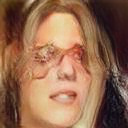

In [102]:
for batch_num in range(num_samples):
  z_batch = z[[batch_num], :]
  y_batch = y[[batch_num]]
  
  ims = []
  
  alphas = np.zeros(shape=(1, 1))
  alpha_for_graph = np.array([au1, au2, au4, au5, au6, au7, au9, au10, au12, au14, au15, au17, au20, au23, au25, au26, au45]).reshape(1, 17)
  
  for i in range(alphas.shape[0]):
    
    alpha_for_graph = transform.scale_test_alpha_for_graph(alphas[i], 1) # , channel=0) # can add channel for color
    alpha_tensor = torch.tensor(alpha_for_graph, device='cuda', dtype=torch.float32)

    print(alpha_tensor.shape)
    
    with torch.no_grad():
      z_new = z_batch
      for i in range(transform.Nsliders):
        z_new = z_new + alpha_tensor[:,i].unsqueeze(1) * w[:,:,i]
    #   out_im = G(z_new, G.shared(y_batch))
      out_im = netG.forward(z_new)
    ims.append(out_im) 
    
  image_grid = torchvision.utils.make_grid(
    torch.cat(ims),
    nrow=1,
    normalize=True,
  )
  image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
  image_grid_np = np.uint8(image_grid_np)
  IPython.display.display(Image.fromarray(image_grid_np))

In [78]:
z_new

tensor([[ 1.5507e+00,  6.4882e-01,  2.7296e-02, -4.0791e-01,  6.8847e-01,
          4.2692e-01, -9.4491e-01,  1.5732e-01, -2.1254e+00, -1.5808e-01,
          2.0588e+00,  1.4157e+00,  1.1407e-01,  2.6757e-01,  7.1306e-02,
          9.4317e-02, -6.8404e-01, -2.9482e-03,  1.4330e+00, -1.0281e+00,
          6.0726e-01, -7.5972e-01,  1.0802e+00,  7.5376e-01, -1.1297e+00,
          1.1513e-01, -7.4755e-01, -2.6264e-01,  5.2739e-01,  5.2689e-01,
         -6.5940e-01, -2.5158e-01, -2.3266e+00, -2.8200e+00,  1.9726e-01,
          2.3110e-01,  3.9129e-01, -1.0445e+00, -3.8140e-01,  1.1083e+00,
          4.5365e-01, -2.5939e-01,  9.3684e-01,  6.7203e-01,  8.9159e-03,
          4.1641e-01, -5.7495e-01,  1.9277e+00, -1.0600e+00, -1.4679e+00,
         -1.1011e+00, -1.0456e+00, -1.3942e+00,  4.3984e-01, -2.2704e-01,
         -4.5264e-01,  5.1019e-01,  5.6140e-01, -8.0282e-01,  4.7097e-01,
         -8.2945e-01, -2.5556e-01, -1.7332e-01, -3.5799e-01, -8.9560e-02,
          5.6684e-03, -3.1418e-02, -1.